In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Load Dataset 

In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
train_df.head(5)




,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Cleaning

In [3]:
def clean(data):
    data = data.copy()
    if 'Name' in data.columns:
        data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        title_map = {'Mr':'Mr','Mrs':'Mrs','Miss':'Miss','Master':'Master'}
        data['Title'] = data['Title'].map(lambda x: title_map.get(x, 'Other'))
        data = pd.get_dummies(data, columns=['Title'], drop_first=False)
    if 'Cabin' in data.columns:
        data['Deck'] = data['Cabin'].astype(str).str[0]  # take first letter
        data['Deck'] = data['Deck'].replace('n', 'Unknown')  # for NaN -> 'n'
        data = pd.get_dummies(data, columns=['Deck'], drop_first=False)
    data.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True, errors='ignore')
    

    if 'Age' in data.columns:
        data['Age'] = data['Age'].fillna(data['Age'].median())
    if 'Fare' in data.columns:
        data['Fare'] = data['Fare'].fillna(data['Fare'].median())
        data['FareLog'] = np.log1p(data['Fare'])

    if 'Embarked' in data.columns:
        data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
        data = pd.get_dummies(data, columns=['Embarked'], drop_first=False)
    if 'Sex' in data.columns:
        data['Sex'] = data['Sex'].replace({'male': 0, 'female': 1})
        data['Sex'] = data['Sex'].fillna(0).astype(int)


    if 'SibSp' in data.columns and 'Parch' in data.columns:
        data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
        data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
        data.drop(['SibSp','Parch'], axis=1, inplace=True, errors='ignore')

    if 'Fare' in data.columns and 'FamilySize' in data.columns:
        data['FarePerPerson'] = data['Fare'] / data['FamilySize']
    if 'Age' in data.columns:
        data['AgeBin'] = pd.cut(data['Age'], bins=[0,12,19,39,59,80], labels=[0,1,2,3,4])
    data['Sex_Pclass'] = data['Sex'] * data['Pclass']


    
    return data

# Separate target if available
if 'Survived' in train_df.columns:
    y_train = train_df['Survived'].copy()
    train_X = train_df.drop('Survived', axis=1)
else:
    y_train = None
    train_X = train_df.copy()

# Clean train and test
train = clean(train_X)
test = clean(test_df)

# Align features so train and test have identical columns
train, test = train.align(test, join="left", axis=1, fill_value=0)

# Add back target column
if y_train is not None:
    train['Survived'] = y_train.values

train.head(100)


,Pclass,Sex,Age,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Deck_A,...,FareLog,Embarked_C,Embarked_Q,Embarked_S,FamilySize,IsAlone,FarePerPerson,AgeBin,Sex_Pclass,Survived
0,3,0,22.0,7.2500,False,False,True,False,False,False,...,2.110213,False,False,True,2,0,3.62500,2,0,0
1,1,1,38.0,71.2833,False,False,False,True,False,False,...,4.280593,True,False,False,2,0,35.64165,2,1,1
2,3,1,26.0,7.9250,False,True,False,False,False,False,...,2.188856,False,False,True,1,1,7.92500,2,3,1
3,1,1,35.0,53.1000,False,False,False,True,False,False,...,3.990834,False,False,True,2,0,26.55000,2,1,1
4,3,0,35.0,8.0500,False,False,True,False,False,False,...,2.202765,False,False,True,1,1,8.05000,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3,0,28.0,8.0500,False,False,True,False,False,False,...,2.202765,False,False,True,1,1,8.05000,2,0,0
96,1,0,71.0,34.6542,False,False,True,False,False,True,...,3.573867,True,False,False,1,1,34.65420,4,0,0
97,1,0,23.0,63.3583,False,False,True,False,False,False,...,4.164466,True,False,False,2,0,31.67915,2,0,1
98,2,1,34.0,23.0000,False,False,False,True,False,False,...,3.178054,False,False,True,2,0,11.50000,2,2,1


## modelling


Default (threshold=0.5)
Accuracy: 0.8491620111731844
Confusion matrix:
 [[100  10]
 [ 17  52]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       110
           1       0.84      0.75      0.79        69

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179


Best threshold: 0.50 | Best F1: 0.794
Accuracy: 0.8491620111731844
Confusion matrix at best threshold:
 [[100  10]
 [ 17  52]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       110
           1       0.84      0.75      0.79        69

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179



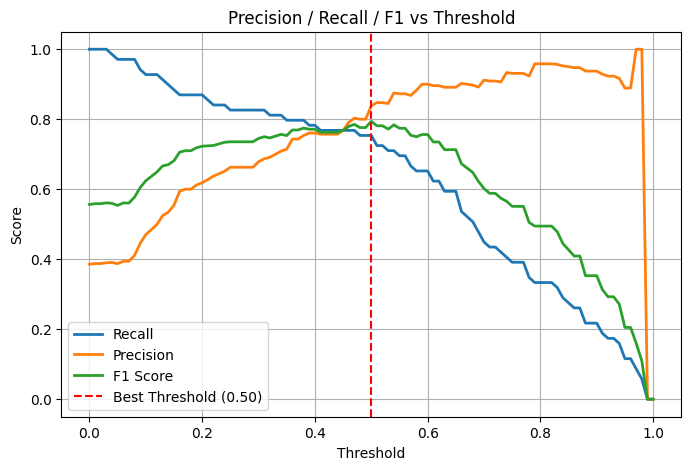

In [4]:

# --- split data ---
X = train.drop("Survived", axis=1)
y = train["Survived"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- train logistic regression ---
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# --- baseline predictions (threshold=0.5) ---
y_pred_default = log_reg.predict(X_val)
print("Default (threshold=0.5)")
print("Accuracy:", accuracy_score(y_val, y_pred_default))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred_default))
print(classification_report(y_val, y_pred_default))

# --- probability scores ---
y_probs = log_reg.predict_proba(X_val)[:, 1]

# --- search for best threshold (maximize F1) ---
best_t, best_f1 = 0.5, 0
for t in np.linspace(0, 1, 101):  # thresholds 0.00 → 1.00
    y_pred_t = (y_probs >= t).astype(int)
    f1 = f1_score(y_val, y_pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"\nBest threshold: {best_t:.2f} | Best F1: {best_f1:.3f}")

# --- evaluate with best threshold ---
y_pred_best = (y_probs >= best_t).astype(int)
print("Accuracy:", accuracy_score(y_val, y_pred_best))
print("Confusion matrix at best threshold:\n", confusion_matrix(y_val, y_pred_best))
print(classification_report(y_val, y_pred_best))

# --- plot recall, precision, F1 vs threshold ---
thresholds = np.linspace(0, 1, 101)
recalls, precisions, f1s = [], [], []
for t in thresholds:
    y_pred_t = (y_probs >= t).astype(int)
    recalls.append(recall_score(y_val, y_pred_t))
    precisions.append(precision_score(y_val, y_pred_t))
    f1s.append(f1_score(y_val, y_pred_t))

plt.figure(figsize=(8,5))
plt.plot(thresholds, recalls, label="Recall", linewidth=2)
plt.plot(thresholds, precisions, label="Precision", linewidth=2)
plt.plot(thresholds, f1s, label="F1 Score", linewidth=2)
plt.axvline(best_t, color='red', linestyle='--', label=f"Best Threshold ({best_t:.2f})")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision / Recall / F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()



## predicting with test set


In [5]:
# Train final model on full training set
X_full = train.drop("Survived", axis=1)
y_full = train["Survived"]

final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_full, y_full)
test_probs = final_model.predict_proba(test)[:, 1]
best_t = 0.37   # use your actual best threshold
test_preds = (test_probs >= best_t).astype(int)
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],  # from original uncleaned test_df
    "Survived": test_preds
})
submission.to_csv("submission.csv", index=False)

